In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing

# Data Science For Business Project

# Step 1

## Preprocessing

In [2]:
# Load file (we keep the git repo as light as possible by only hosting the .gz's)
!rm -f *.json
!gunzip -c amazon_step1.json.gz > amazon_step1.json

# A first look at the data
df1 = pd.read_json('amazon_step1.json', lines=True)
df1.head()

,asin,category,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000J4HXUC,Sports_and_Outdoors,"[1, 1]",5,It's a .50 Caliber Ammo Can. That largely sums...,"01 5, 2014",A3QRW0UJPKIAX7,Grant Fritchey,Clean and Exactly as Advertised,1388880000
1,0983393214,Books,"[0, 0]",5,This was a very good book. It kept me excited ...,"06 23, 2013",A2SEIOM4H06WTH,TJ,Great read!,1371945600
2,B003G4FVMY,Grocery_and_Gourmet_Food,"[0, 0]",5,"If you love coconut the way I do, you can't go...","05 19, 2013",A3GDEXMU9587JX,"K. Parsley ""kindlekat""","If you love coconut, get this coffee",1368921600
3,B00F9VRNF0,Cell_Phones_and_Accessories,"[0, 0]",5,I recently switched from the Galaxy S3 to the ...,"04 25, 2014",ASP3J2NEHDN4E,ChriS,Superior Protection!!!,1398384000
4,B00D5OZQUC,Amazon_Instant_Video,"[0, 0]",5,"Good show,looks like the gap from season 2 to ...","11 4, 2013",A1EDBI6TBKP9CO,Grants Book Trade,"Love the show, thanks for putting Season 3 on ...",1383523200


In [3]:
df1.dtypes

asin              object
category          object
helpful           object
overall            int64
reviewText        object
reviewTime        object
reviewerID        object
reviewerName      object
summary           object
unixReviewTime     int64
dtype: object

In [4]:
# Analyze the data: features and sample
num_total_samples = len(df1.index)
num_total_features = len(df1.columns)
print("Number of features:", num_total_features)
print("Number of samples:", num_total_samples)

Number of features: 10
Number of samples: 96000


In [5]:
# Start by counting the number of valid entrie per sample
num_valid_entries_per_sample = df1.count(axis=1)
# Then compute the total number of complete samples
num_complete_samples = num_valid_entries_per_sample.tolist().count(num_total_features)

# We can now compute the percenter of damaged sample
percentage_damaged_samples = 1 - num_complete_samples/num_total_samples
print('Number of damaged samples:', num_total_samples - num_complete_samples)
print('Percentage of damaged Samples:', np.around(100*percentage_damaged_samples,decimals=1), '%')

Number of damaged samples: 994
Percentage of damaged Samples: 1.0 %


It appears that we have some missing data. <br />
Let's see the number of valid entries for each feature

In [6]:
num_valid_entries_per_feature = df1.count(axis=0).sort_values()
print("Number of valid entrie perf feature: ")
print(num_valid_entries_per_feature)

Number of valid entrie perf feature: 
reviewerName      95006
asin              96000
category          96000
helpful           96000
overall           96000
reviewText        96000
reviewTime        96000
reviewerID        96000
summary           96000
unixReviewTime    96000
dtype: int64


Only `reviewerName` is sometimes missing (994 times to be precise).

In [7]:
df1.isnull().sum()

asin                0
category            0
helpful             0
overall             0
reviewText          0
reviewTime          0
reviewerID          0
reviewerName      994
summary             0
unixReviewTime      0
dtype: int64

## We now present the preprocessing choices for each features

As stated in the project description, we will mainly rely on the **reviewText** feature. Nevertheless, we decide to take a look into each other feature and try to see if we can extract some useful information from them in order to help our models.

### asin
> Defintion: `amazon standard identification number which is unique for each product`

This feature will obvisously not bring useful information for the task we want to perform. We drop it.

In [8]:
df1 = df1.drop(['asin'], axis=1)

### category
> Definition: `category of the product`

This is the target feature for part I of the project.<br />
We see below that the frequency of each category is equal<br />
This is a great news since we will be able to use a simple accuracy score to rank our different models.<br />
Moreover, it will be easy to sample a subset of the dataset if need be (e.g. to test a model on small data to improve speed).

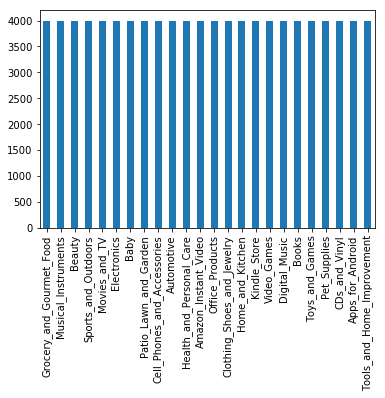

In [9]:
import matplotlib.pyplot as plt
df1["category"].value_counts().plot(kind='bar')
plt.show()

### helpful
> Definition: `[x,y]: x is the number of helpful ticks and y is the number of total ticks`

This features is not useful in it's actual form, but we think that we can take advantage of the information it contains. Indeed, it's reasonable to think that a five stars product might have a bigger ratio x/y than a one start product. Therefore, we decide to create a new feature from the *helpful* one: **helpfulPercentage**.

In [10]:
# Compute the new feature 'helpfulPercentage'
df1["helpfulPercentage"] = df1.helpful.apply(lambda x: x[0]/x[1] if x[1] != 0 else 0)

# Remove the 'old' one
df1 = df1.drop(["helpful"], axis=1)

df1.helpfulPercentage.sample(5)

10725    0.0
62701    0.0
15672    0.0
886      0.5
54589    1.0
Name: helpfulPercentage, dtype: float64

### overall
> Definition: `overal rating of the product in the range of [1,2,3,4,5]`

This is the target feature for parts II and II of the project

In [11]:
df1.groupby("category")["overall"].mean()

category
Amazon_Instant_Video           4.21125
Apps_for_Android               3.96325
Automotive                     4.45325
Baby                           4.22200
Beauty                         4.18700
Books                          4.26575
CDs_and_Vinyl                  4.27800
Cell_Phones_and_Accessories    4.12600
Clothing_Shoes_and_Jewelry     4.25000
Digital_Music                  4.22650
Electronics                    4.23575
Grocery_and_Gourmet_Food       4.25825
Health_and_Personal_Care       4.24675
Home_and_Kitchen               4.32525
Kindle_Store                   4.35850
Movies_and_TV                  4.12200
Musical_Instruments            4.49550
Office_Products                4.34450
Patio_Lawn_and_Garden          4.21875
Pet_Supplies                   4.22325
Sports_and_Outdoors            4.40150
Tools_and_Home_Improvement     4.35275
Toys_and_Games                 4.38350
Video_Games                    4.09725
Name: overall, dtype: float64

### reviewText
> Definition: `text of the review`

This is the main feature on which we need to rely on. It's text, so we need to transform it into a numerical form.

But before doing so, we decided to extract some information from this feature.

Firstly, we create a new feature **reviewTextLenght**. The name describe perfectly the feature.

In [12]:
# Compute the feature
df1["reviewTextLength"] = df1["reviewText"].apply(lambda x: len(x))

# We standardize it: that way, outliers (e.g. very long comments) won't affect too much our model
df1["reviewTextLength"] = preprocessing.scale(pd.to_numeric(df1["reviewTextLength"]))

df1.reviewTextLength.sample(5)

/home/com402/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


80521   -0.565376
17077   -0.373401
72832   -0.626515
43331    0.046011
64536    0.980210
Name: reviewTextLength, dtype: float64

We also create features that capture the amount of punctuation that is used, namely *points*, *exclamation marks*, *question marks*, and *comas*. 

In [13]:
def count_char(row, char):
    return row.count(char)

df1["rtCountPoints"] = df1["reviewText"].apply(count_char, args=("."))
df1["rtCountPoints"] = preprocessing.scale(df1["rtCountPoints"])

df1["rtCountExcl"] = df1["reviewText"].apply(count_char, args=("!"))
df1["rtCountExcl"] = preprocessing.scale(df1["rtCountExcl"])

df1["rtCountInterr"] = df1["reviewText"].apply(count_char, args=("?"))
df1["rtCountInterr"] = preprocessing.scale(df1["rtCountInterr"])

df1["rtCountComas"] = df1["reviewText"].apply(count_char, args=(","))
df1["rtCountComas"] = preprocessing.scale(df1["rtCountComas"])

# Output some sample
df1[["rtCountPoints", "rtCountExcl", "rtCountInterr", "rtCountComas"]].sample(5)

/home/com402/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


,rtCountPoints,rtCountExcl,rtCountInterr,rtCountComas
31789,-0.253817,-0.341411,-0.218245,-0.441073
49696,-0.037060,-0.341411,-0.218245,0.065674
22177,-0.470575,-0.341411,-0.218245,-0.567760
57739,-0.578953,0.215455,-0.218245,-0.441073
88761,1.371863,0.215455,-0.218245,1.079169


In [14]:
(df1.reviewText.apply(lambda x : (":)" in x))).sum()

1121

We decide to already buil the pipeline we will use for this feature. We need to transform this textual feature into a numerical one.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import EnglishStemmer

In [16]:
stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

stop_words = 'english'

pipe_modified = Pipeline([('vectorize_stem', CountVectorizer(stop_words=stop_words,analyzer=stemmed_words)),\
                          ('compute_tfidf', TfidfTransformer())])

### reviewTime
> Definition: `time of writing the review in normal format`

We think that we cannot retrieve useful information from this features. We decide to drop it.

In [17]:
df1 = df1.drop(["reviewTime"], axis=1)

### reviewerID
> Definition: `id of the reviewer`

We drop it also, no information that we can use.

In [18]:
df1 = df1.drop(['reviewerID'], axis=1)

> **A FAIRE SI ON A LE TEMPS**
>
>On peut imaginer qu'un user note seulement les produits d'une seule catégorie donc je pensais utiliser ça. Le seul moen que j'ai en tête est un peu tiré parles cheveux, donc je préfére le laisser de coté, si on a le temps on essaie, sinon on peut même le garder pour le présentation, si on a une question genre "What can you do to improve your work bla bla bla".
>
>L'idée serait de créer une feature par categorie pour chaque utilisateur qu'on a dans notre training data. La valeur de la features serait par exemple le pourcentage de parmis les produits que l'user a note, combien appartienne à cette catégorie

This one is a little more tricky. We can make the assumption that some people only rate negatively all products, so named "trolls", or that a persone only rate products for a given categorie. Therefore, we investigate it.
a = df1.groupby('reviewerID')['category'].apply(lambda x: list(x))

### reviewerName
> Definition: `name of the reviewer`

We decide to drop this feature, as it is redundant with the reviewerId (even if a reviewerID might be associated with multiples reviewerNames). Since we drop this feature, no need to taking care of the missing values.

In [19]:
df1 = df1.drop(["reviewerName"], axis=1)

### summary
> Defintion: `a summary of reviewer's opinion about the product`

Let's look at this feature, with the **reviewText** next to it.

In [20]:
df1[["reviewText", "summary"]]

,reviewText,summary
0,It's a .50 Caliber Ammo Can. That largely sums...,Clean and Exactly as Advertised
1,This was a very good book. It kept me excited ...,Great read!
2,"If you love coconut the way I do, you can't go...","If you love coconut, get this coffee"
3,I recently switched from the Galaxy S3 to the ...,Superior Protection!!!
4,"Good show,looks like the gap from season 2 to ...","Love the show, thanks for putting Season 3 on ..."
5,"I'm ordering more of these spoons, as one just...",Perfect for babies
6,We installed some sensor lights in the house f...,"Nice little sensor light, good for power fail..."
7,It was 1979 and the B-52s were on Saturday Nig...,Defining An Era
8,My Manchester terrier eats so fast she chokes ...,Perfect Solution For Dogs That Gobble Food Too...
9,This movie starts off with some clever and fun...,Reverse Cinderella just doesn't cut it.


As for the reviewText, we think that thise feature is really useful.

### unixReviewTime
> Definition: `time of writing the review in UNIX format`

This feature is redudant with **reviewTime**. We also drop it.

In [21]:
df1 = df1.drop(["unixReviewTime"], axis=1)

## Preprocessing results
We give below an overview of the final data frame that we will be using.

In [22]:
df1.head()

,category,overall,reviewText,summary,helpfulPercentage,reviewTextLength,rtCountPoints,rtCountExcl,rtCountInterr,rtCountComas
0,Sports_and_Outdoors,5,It's a .50 Caliber Ammo Can. That largely sums...,Clean and Exactly as Advertised,1.0,-0.106836,0.396455,-0.341411,-0.218245,-0.187700
1,Books,5,This was a very good book. It kept me excited ...,Great read!,0.0,-0.627738,-0.470575,-0.341411,-0.218245,-0.567760
2,Grocery_and_Gourmet_Food,5,"If you love coconut the way I do, you can't go...","If you love coconut, get this coffee",0.0,-0.547035,-0.687332,0.215455,-0.218245,-0.441073
3,Cell_Phones_and_Accessories,5,I recently switched from the Galaxy S3 to the ...,Superior Protection!!!,0.0,1.256557,1.155105,1.886052,-0.218245,-0.314387
4,Amazon_Instant_Video,5,"Good show,looks like the gap from season 2 to ...","Love the show, thanks for putting Season 3 on ...",0.0,-0.573936,-0.578953,-0.341411,2.760569,-0.187700


## Training, tuning and testing of models

In [23]:
# The target feature --> CATEGORY
y = df1.category

In [24]:
# The features we will use
featuresToUse = ["helpfulPercentage", "reviewTextLength", "rtCountPoints", "rtCountExcl", "rtCountInterr", "rtCountComas"]

# Features we will not use : OVERALL

# Features to transfrom from textual to numerical representation: REVIEWTEXT and SUMMARY
# ---- ReviewText
pipe_modified.fit(df1.reviewText)
x_reviewText = pipe_modified.transform(df1.reviewText)

# ---- Summary
pipe_modified.fit(df1.summary)
x_summary = pipe_modified.transform(df1.summary)

In [25]:
# Now we can combine all features into a single dataframe
from scipy.sparse import hstack
X = hstack((x_reviewText, x_summary))

In [26]:
for c in featuresToUse:
    X = hstack((X,(df1[c])[:,None]))

In [27]:
X.shape

(96000, 108303)

In [28]:
from sklearn.cross_validation import train_test_split
seed = 2017
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

/home/com402/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

print("X_test:  ", X_test.shape)
print("y_test:  ", y_test.shape)

X_train:  (76800, 108303)
y_train:  (76800,)
X_test:   (19200, 108303)
y_test:   (19200,)


In [30]:
def print_precision(y_t, y_pred):
    p_and_rec=precision_recall_fscore_support(y_t,y_pred)
    precision = p_and_rec[0]
    recall = p_and_rec[1]
    f_measure = p_and_rec[2]
    support = p_and_rec[3]
    print("Precision mean: ", np.mean(precision))

### Baseline model (Dummy Classifier)

In [31]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.dummy import DummyClassifier
baselineModel = DummyClassifier(random_state=seed)
baselineModel.fit(X_train,y_train)
y_pred = baselineModel.predict(X_test)

print_precision(y_test, y_pred)
print("1 / 24 = ", 1/24)

Precision mean:  0.0447061846207
1 / 24 =  0.041666666666666664


### Linear SVM with Stochastic Gradient Descent

In [38]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.001, 0.0001, 0.00001, 0.000001]
}
cv = KFold(n_splits=10, random_state=seed)
sgd = GridSearchCV(SGDClassifier(loss="hinge", random_state=seed), parameters,
     scoring="accuracy", cv=cv)

runGridSearch = False
if (runGridSearch):
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.001, random_state=seed)
    X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(X_train_s, y_train_s, test_size=0.2, random_state=seed)
    sgd.fit(X_train_s1, y_train_s1)
    y_pred = sgd.predict(X_test_s1)

    print_precision(y_test_s1, y_pred)
    print("Best params:", sgd.best_estimator_.get_params())
else:
    print("Precision mean:  0.715339752809,\nBest params: {'alpha': 1e-05, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter': 5, 'n_jobs': 1, 'penalty': 'l1', 'power_t': 0.5, 'random_state': 2017, 'shuffle': True, 'verbose': 0, 'warm_start': False}")

Precision mean:  0.715339752809,
Best params: {'alpha': 1e-05, 'average': False, 'class_weight': None, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter': 5, 'n_jobs': 1, 'penalty': 'l1', 'power_t': 0.5, 'random_state': 2017, 'shuffle': True, 'verbose': 0, 'warm_start': False}


### Logistic Regressor with SGD

In [34]:
from sklearn.linear_model import SGDClassifier
sgd_log = SGDClassifier(loss='log', penalty='l2', alpha=1e-3, n_iter=5, random_state=seed)
sgd_log.fit(X_train, y_train)
y_pred = sgd_log.predict(X_test)

print_precision(y_test, y_pred)

Precision mean:  0.626854517112


### KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=24)
knn.fit(X_train, y_train)
#y_pred = knn.predict(X_test)

#print_precision(y_test, y_pred)
# J'ai une memory error, sûrement du à la setup de ma vm

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfg = RandomForestRegressor()
# todo
#rfg.fit(X_train, pipe_modified.transform(y_train))
#y_pred = rfg.predict(X_test)
#print_precision(y_test, y_pred)

## Model comparison and best model
We simply rank a model based on the accuracy it is capable to achieve.<br />
We thus select the [TODO] Linear SVM model.

## Prediction of the unseen data

In [ ]:
!gunzip -c amazon_step1_unseen.csv.gz > amazon_step1_unseen.csv
df1_unseen = pd.read_csv("amazon_step1_unseen.csv")

# We apply all the modifications on this dataframe. A pipeline may have been cleaner...
df1_c = df1_unseen.copy(deep=True)
df1_c = df1_c.drop(['asin', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime'], axis=1)
df1_c["helpfulPercentage"] = df1_c.helpful.apply(lambda x: x[0]/x[1] if x[1] != 0 else 0)
df1_c = df1_c.drop(["helpful"], axis=1)
df1_c["reviewTextLength"] = df1_c["reviewText"].apply(lambda x: len(x))
df1_c["reviewTextLength"] = preprocessing.scale(pd.to_numeric(df1_c["reviewTextLength"]))

df1_c["rtCountPoints"] = df1_c["reviewText"].apply(count_char, args=("."))
df1_c["rtCountPoints"] = preprocessing.scale(df1_c["rtCountPoints"])

df1_c["rtCountExcl"] = df1_c["reviewText"].apply(count_char, args=("!"))
df1_c["rtCountExcl"] = preprocessing.scale(df1_c["rtCountExcl"])

df1_c["rtCountInterr"] = df1_c["reviewText"].apply(count_char, args=("?"))
df1_c["rtCountInterr"] = preprocessing.scale(df1_c["rtCountInterr"])

df1_c["rtCountComas"] = df1_c["reviewText"].apply(count_char, args=(","))
df1_c["rtCountComas"] = preprocessing.scale(df1_c["rtCountComas"])

featuresToUse = ["helpfulPercentage", "reviewTextLength", "rtCountPoints", "rtCountExcl", "rtCountInterr", "rtCountComas"]
pipe_modified.fit(df1_c.reviewText)
x_reviewText = pipe_modified.transform(df1_c.reviewText)
pipe_modified.fit(df1_c.summary)
x_summary = pipe_modified.transform(df1_c.summary)

X = hstack((x_reviewText, x_summary))
for c in featuresToUse:
    X = hstack((X,(df1[c])[:,None]))
    
print(X)

# Step 2

In this step we want to predict wheter a product review has a ranking of 5 or not (1 or 0).

## Preprocessing

In [ ]:
!gunzip -c amazon_step23.json.gz > amazon_step23.json
with open('amazon_step23.json') as f:
   content = f.readlines()

df2 = pd.read_json("".join(content), lines=True)

# We apply first the same modifications as in step 1:
df2 = df2.drop(['asin', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime'], axis=1)
df2["helpfulPercentage"] = df2.helpful.apply(lambda x: x[0]/x[1] if x[1] != 0 else 0)
df2 = df2.drop(["helpful"], axis=1)
df2["reviewTextLength"] = df2["reviewText"].apply(lambda x: len(x))
df2["reviewTextLength"] = preprocessing.scale(pd.to_numeric(df2["reviewTextLength"]))

df2["rtCountPoints"] = df2["reviewText"].apply(count_char, args=("."))
df2["rtCountPoints"] = preprocessing.scale(df2["rtCountPoints"])

df2["rtCountExcl"] = df2["reviewText"].apply(count_char, args=("!"))
df2["rtCountExcl"] = preprocessing.scale(df2["rtCountExcl"])

df2["rtCountInterr"] = df2["reviewText"].apply(count_char, args=("?"))
df2["rtCountInterr"] = preprocessing.scale(df2["rtCountInterr"])

df2["rtCountComas"] = df2["reviewText"].apply(count_char, args=(","))
df2["rtCountComas"] = preprocessing.scale(df2["rtCountComas"])

featuresToUse = ["helpfulPercentage", "reviewTextLength", "rtCountPoints", "rtCountExcl", "rtCountInterr", "rtCountComas"]
pipe_modified.fit(df2.reviewText)
x_reviewText = pipe_modified.transform(df2.reviewText)
pipe_modified.fit(df2.summary)
x_summary = pipe_modified.transform(df2.summary)

X = hstack((x_reviewText, x_summary))
for c in featuresToUse:
    X = hstack((X,(df2[c])[:,None]))
    
# Then we create BIN_OVERALL that is equal to 1 if rank is 5, and 0 otherwise
df2["BIN_OVERALL"] = 1 * df2["overall"] == 5

# We can also make us of positive (http://ptrckprry.com/course/ssd/data/positive-words.txt) and
# negative (http://ptrckprry.com/course/ssd/data/negative-words.txt) word lists.
# For example, if a review contains only negative words, we guess the rating is not 5, and vice-versa
# We could also use the ratio good/(good + bad)
# TODO: what if the review contains negations (e.g. [...] not cool [...]) ?

df2.head()

/home/com402/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


# Step 3
## Preprocessing